<a href="https://colab.research.google.com/github/Bast1-py/Experience-Developing-Projects/blob/main/Text_Classification_and_Analysis_of_E_commerce_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset yang digunakan diambil dari Open Source: https://zenodo.org/records/3355823

**Tujuan**


Mengembangkan model klasifikasi teks untuk mengkategorikan ulasan produk e-commerce menggunakan teknik Natural Language Processing (NLP). Proyek ini mencakup praproses data, analisis data eksploratori (EDA), pembuatan model, dan evaluasi pengklasifikasi pembelajaran mesin.

Data Acquisition and Preparation:
* Memuat dan membersihkan kumpulan data ulasan e-commerce, memastikan integritas data dengan menangani nilai yang hilang dan mengubah label kategoris menjadi format numerik menggunakan LabelEncoder.


Exploratory Data Analysis (EDA):
* Melakukan EDA untuk memvisualisasikan distribusi label dan karakteristik teks menggunakan Matplotlib dan Seaborn.
* Membuat awan kata untuk mewakili kata-kata yang sering muncul dan memvisualisasikan distribusi panjang teks untuk label yang berbeda.


Text Preprocessing:
* Menerapkan fungsi pembersihan teks yang komprehensif untuk menghapus tag HTML, URL, karakter khusus, dan stopword menggunakan BeautifulSoup dan ekspresi reguler.
* Memanfaatkan NLTK untuk tokenisasi dan penghapusan stopword guna menyiapkan data teks untuk analisis.


Feature Engineering:
* Menggunakan vektorisasi TF-IDF untuk mengubah data tekstual menjadi format terstruktur yang sesuai untuk algoritma pembelajaran mesin.
* Menjelajahi penyematan FastText untuk menyempurnakan representasi kata, menangkap hubungan semantik antar kata.


Model Development:
* Melatih pengklasifikasi Multinomial Naive Bayes dan mengevaluasi kinerjanya menggunakan metrik akurasi, matriks kebingungan, dan kurva ROC.

* Mengembangkan jaringan saraf berulang (RNN) menggunakan TensorFlow dengan lapisan GRU untuk menangkap dependensi berurutan dalam data teks, mengoptimalkan akurasi melalui validasi model.


Performance Evaluation:
* Mengevaluasi beberapa model dengan metrik seperti Kappa Cohen, kehilangan skor Brier, dan skor ROC AUC untuk menilai kualitas klasifikasi.

* Performa model yang divisualisasikan melalui matriks kebingungan, kurva ROC, dan plot riwayat pelatihan untuk memberikan wawasan tentang perilaku model.

In [ ]:
import re, gensim, nltk, string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import unicodedata
import tensorflow as tf

from PIL import Image
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup
from itertools import chain
from itertools import cycle
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, cohen_kappa_score, brier_score_loss
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding, Dense, GRU, Dropout
from gensim.models.fasttext import FastText
from yellowbrick.classifier import ROCAUC

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
gambar = np.array(Image.open('/content/il_1140xN.1287758547_2nwc.png'))

In [ ]:
df = pd.read_csv('/content/ecommerceDataset.csv', names=['label','text'])
df.head(11)

,label,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...
5,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
6,Household,Paper Plane Design Starry Night Vangoh Wall Ar...
7,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
8,Household,SAF 'Ganesh Modern Art Print' Painting (Synthe...
9,Household,Paintings Villa UV Textured Modern Art Print F...


In [ ]:
df.shape

(50425, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   50425 non-null  object
 1   text    50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.label.value_counts()

,count
label,
Household,19313
Books,11820
Electronics,10621
Clothing & Accessories,8670


<ipython-input-23-ea07d6a6c26f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label',


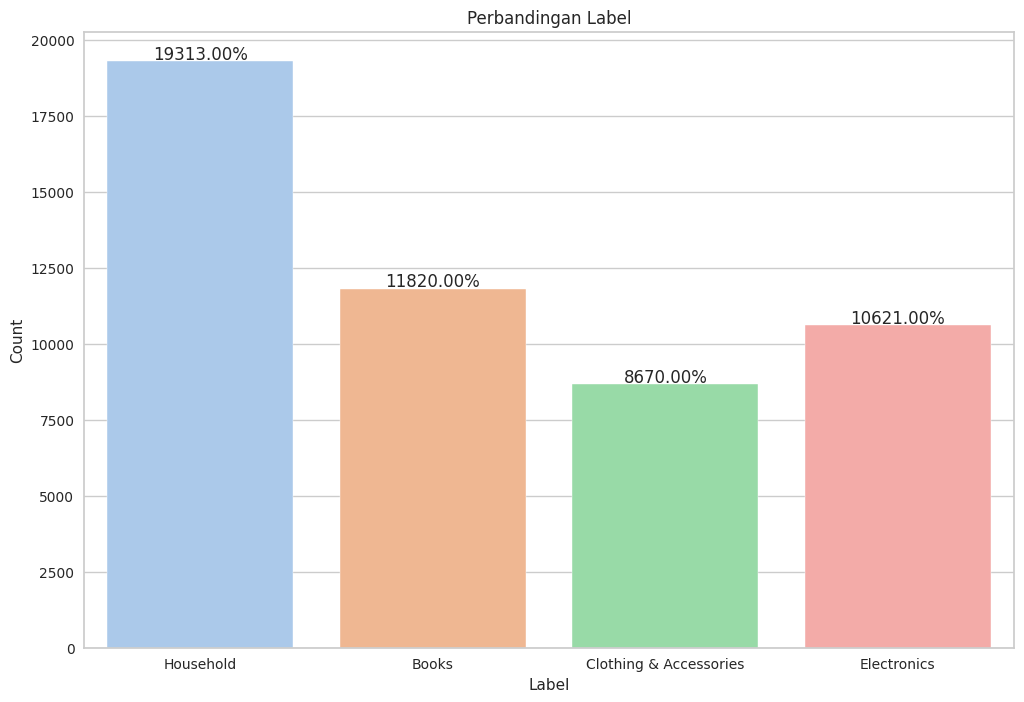

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,8))
ax = sns.countplot(x='label',
                   data=df,
                   palette='pastel')


for p in ax.patches:
    ax.annotate('{:.2f}%'.format(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0,5), textcoords='offset points')

plt.ylabel('Count')
plt.xlabel('Label')
plt.title('Perbandingan Label')
plt.show()

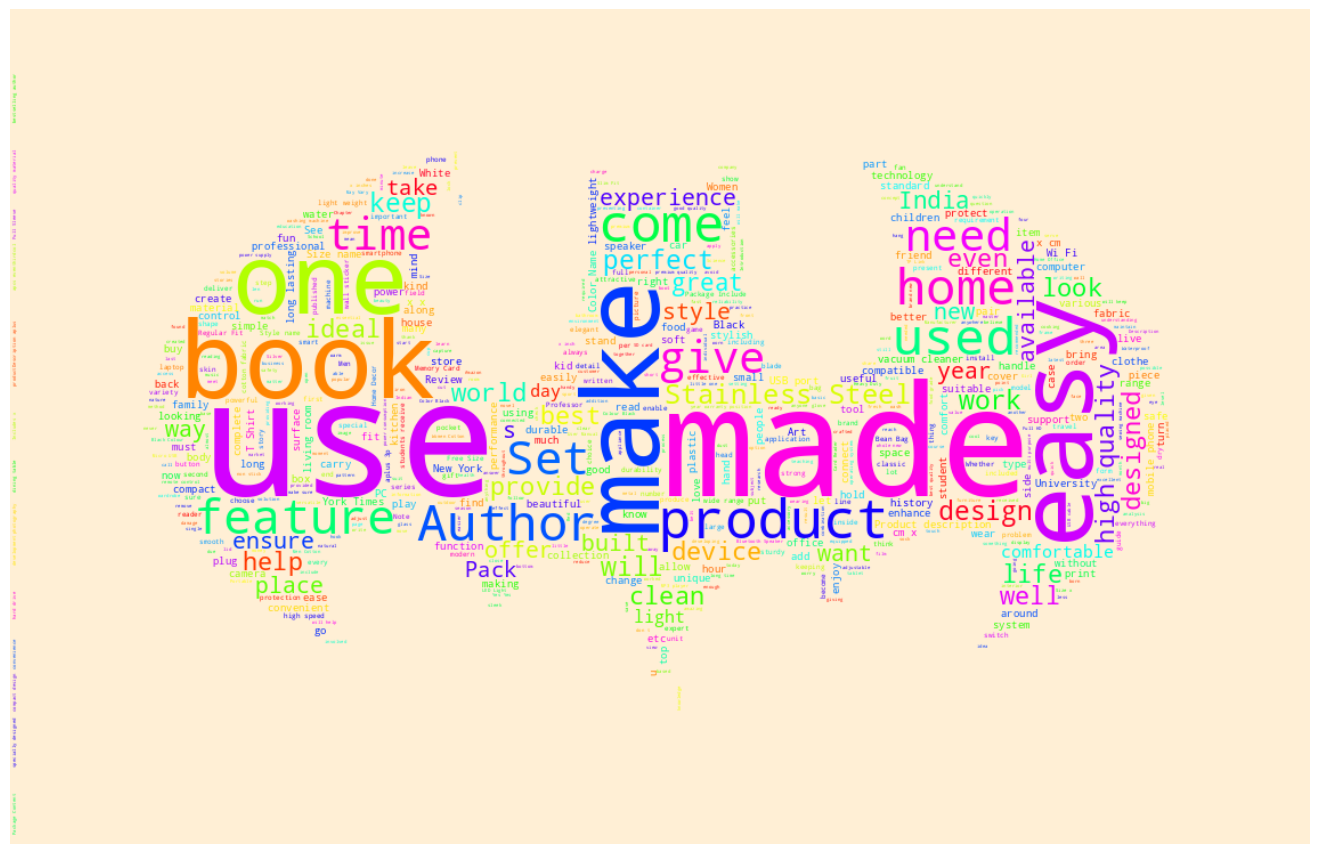

In [ ]:
all_text = df['text'].str.cat(sep=' ')
plt.figure(figsize=(13,10))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=850,
                      height=850,
                      max_words=1100,
                      mask=gambar,
                      background_color='papayawhip',
                      colormap='gist_rainbow',
                      stopwords=stopwords).generate(all_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
label_encoder = LabelEncoder()
df['label1'] = label_encoder.fit_transform(df['label'])
df.head(11)

,label,text,label1
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,3
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",3
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,3
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",3
4,Household,Incredible Gifts India Wooden Happy Birthday U...,3
5,Household,Pitaara Box Romantic Venice Canvas Painting 6m...,3
6,Household,Paper Plane Design Starry Night Vangoh Wall Ar...,3
7,Household,Pitaara Box Romantic Venice Canvas Painting 6m...,3
8,Household,SAF 'Ganesh Modern Art Print' Painting (Synthe...,3
9,Household,Paintings Villa UV Textured Modern Art Print F...,3


In [ ]:
df['decoded_category'] = label_encoder.inverse_transform(df['label1'])
print(df[['label','label1','decoded_category']])

             label  label1 decoded_category
0        Household       3        Household
1        Household       3        Household
2        Household       3        Household
3        Household       3        Household
4        Household       3        Household
...            ...     ...              ...
50420  Electronics       2      Electronics
50421  Electronics       2      Electronics
50422  Electronics       2      Electronics
50423  Electronics       2      Electronics
50424  Electronics       2      Electronics

[50424 rows x 3 columns]


In [ ]:
df[['label', 'label1', 'decoded_category']].value_counts()

,,,count
label,label1,decoded_category,
Household,3,Household,19313
Books,0,Books,11820
Electronics,2,Electronics,10621
Clothing & Accessories,1,Clothing & Accessories,8670


In [ ]:
df.drop(["label","decoded_category"], axis=1, inplace=True)

In [ ]:
df_analisis = df.copy()

In [ ]:
books = df_analisis[df_analisis["label1"]==0] ["text"].str.len()
cloth_and_accessories = df_analisis[df_analisis["label1"]==1] ["text"].str.len()
electronics = df_analisis[df_analisis["label1"]==2] ["text"].str.len()
household = df_analisis[df_analisis["label1"]==3] ["text"].str.len()

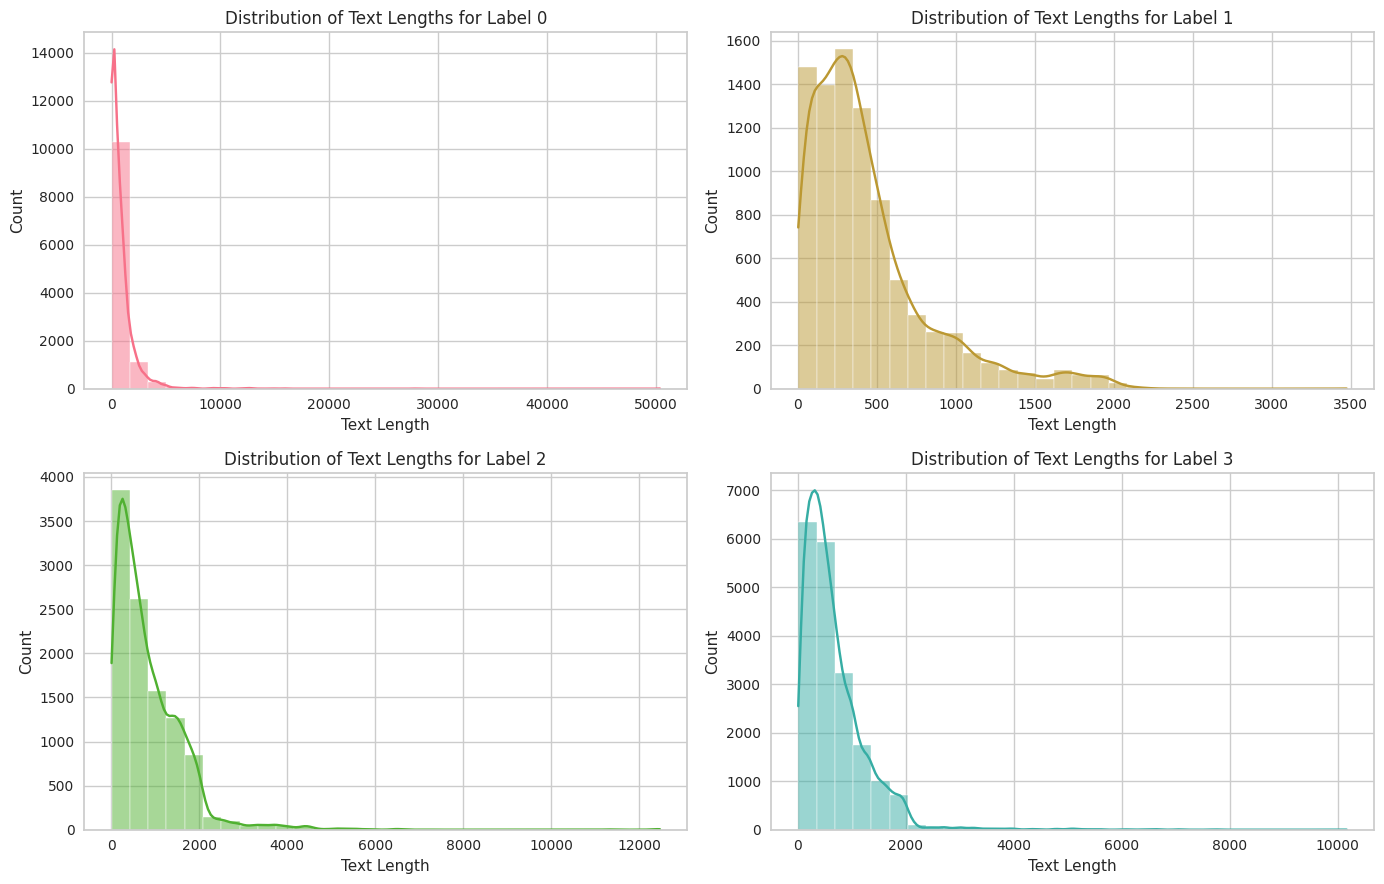

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(14, 9))
axes = axes.flatten()
for label, ax in zip(range(4), axes):
    text_lengths = df_analisis[df_analisis["label1"] == label]["text"].str.len()
    sns.histplot(text_lengths, bins=30, color=sns.color_palette('husl')[label], ax=ax, kde=True)
    ax.set_title(f'Distribution of Text Lengths for Label {label}')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

* Books: 0
* Clothing and Accessories: 1
* Electronics: 2
* Household: 3

<ipython-input-32-d90bc01cdec6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count',
<ipython-input-32-d90bc01cdec6>:9: UserWarning: 
The palette list has fewer values (20) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Count',


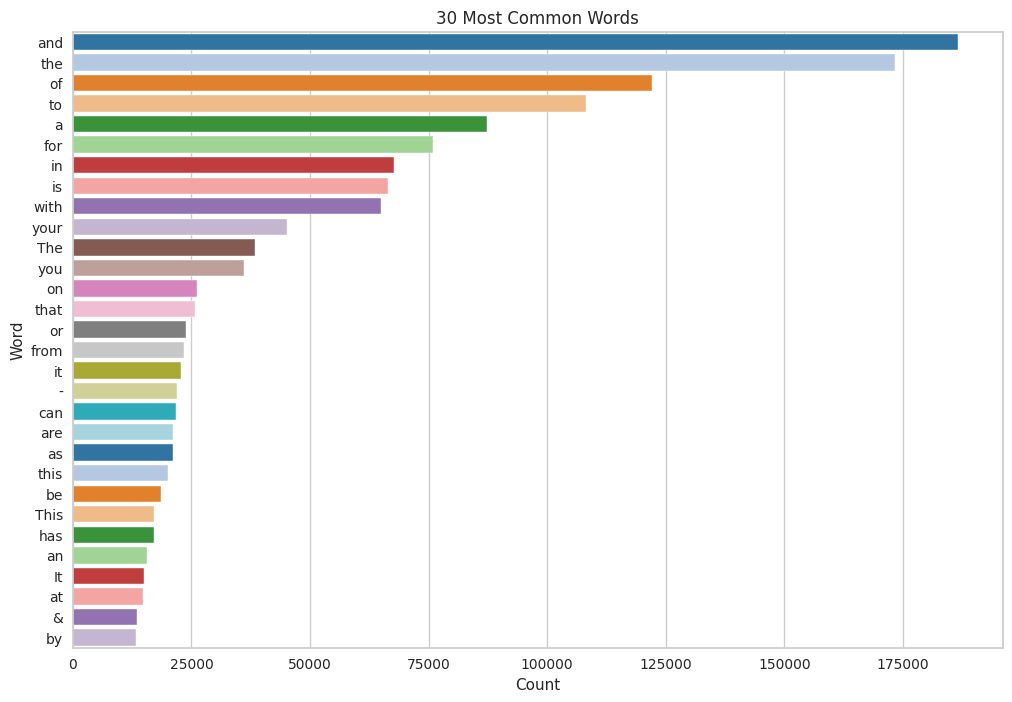

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,8))
dataset = df_analisis['text'].str.split()
all_words = list(chain.from_iterable(dataset))
counter =  Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
colors = sns.color_palette("tab20")
sns.barplot(x='Count',
            y='Word',
            data=df_common_words,
            palette=colors)
plt.title('30 Most Common Words')
plt.ylabel('Word')
plt.xlabel('Count')
plt.show()

In [ ]:
# Membersihkan data
df_analisis['text'][100]

'Embroidery Kit for Beginners DIY Kit Total 15 Iteam This embroidery kit is consists of all the basic items that a beginner will require to learn embroidery. This kit can also be a perfect gift for your loved ones.'

In [ ]:
def clean_text(text):

  # menghapus tag HTML
  if '<' in text:
    text = BeautifulSoup(text, 'html.parser').get_text()

  # menghapus alamat URL
  text = re.sub(r'https?://\S+|www\.\S+', '', text)

  # menghapus karakter beraksen
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

  # menghapus tanda baca
  text = re.sub(r'[^a-zA-Z0-9]', ' ', text)

  # menghapus karakter yang tidak relevan
  text = re.sub(r'[^a-zA-Z]', ' ', text)

  # menghapus spasi tambahan
  text = re.sub(r'\s+', ' ', text).strip()

  # menghapus stopwords
  stop_words = set(stopwords.words('english'))
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]
  text = ' '.join(filtered_words)
  return text

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
df_analisis['text'] = df_analisis['text'].apply(clean_text)

In [ ]:
df_analisis['text'][250]

'anshatrandcraft Candle Making Wicks inch Pieces Color Name Wick Pcs candle wick piece string cord retains flame candle consistent burning candle dependent size wick candle wicks commonly made braided cotton Wick comes various sizes according requirement'

In [ ]:
avg_len = df_analisis['text'].str.len().median()
print('Average Text Length:', avg_len)

Average Text Length: 365.0


In [ ]:
df_analisis.head(11)

,text,label1
0,Paper Plane Design Framed Wall Hanging Motivat...,3
1,SAF Floral Framed Painting Wood inch x inch Sp...,3
2,SAF UV Textured Modern Art Print Framed Painti...,3
3,SAF Flower Print Framed Painting Synthetic inc...,3
4,Incredible Gifts India Wooden Happy Birthday U...,3
5,Pitaara Box Romantic Venice Canvas Painting mm...,3
6,Paper Plane Design Starry Night Vangoh Wall Ar...,3
7,Pitaara Box Romantic Venice Canvas Painting mm...,3
8,SAF Ganesh Modern Art Print Painting Synthetic...,3
9,Paintings Villa UV Textured Modern Art Print F...,3


**TF-IDF (Term Frequency - Inverse Document Frequency)**

In [ ]:
text_data = df_analisis['text']
df_kata = TfidfVectorizer()
df_kata_matrix = df_kata.fit_transform(text_data)
print('TF-IDF Matrix (Sparse Representation):\n', df_kata_matrix)

TF-IDF Matrix (Sparse Representation):
   (0, 50078)	0.04914166651101815
  (0, 15822)	0.05430081452610636
  (0, 24557)	0.08030983242477317
  (0, 14654)	0.07731904332863059
  (0, 29638)	0.09589890529476239
  (0, 44276)	0.05249300307568594
  (0, 33970)	0.10329948088455967
  (0, 48051)	0.08567925105863312
  (0, 34513)	0.10396552901669925
  (0, 64642)	0.11538860471873347
  (0, 22113)	0.08326552581822509
  (0, 60392)	0.10396552901669925
  (0, 20489)	0.05364342028808478
  (0, 22586)	0.060775027809688055
  (0, 18267)	0.07148753223720557
  (0, 52712)	0.07954281015167232
  (0, 40333)	0.07293186987532492
  (0, 11267)	0.054470642481457776
  (0, 49570)	0.05981090954675646
  (0, 34611)	0.13211144996694485
  (0, 18269)	0.05444331635267688
  (0, 26859)	0.07617390719659596
  (0, 7390)	0.060181341481190954
  (0, 6272)	0.10148897005441765
  (0, 19443)	0.10206415967969068
  :	:
  (50422, 1709)	0.04171046651891544
  (50422, 58766)	0.08547948780119428
  (50422, 11370)	0.04801234403515549
  (50422, 24646)	0

In [ ]:
vocabulary = df_kata.get_feature_names_out()
print('Vocabulary:', vocabulary)

Vocabulary: ['aa' 'aaa' 'aaaa' ... 'zz' 'zzy' 'zzzzs']


In [ ]:
label_data = df_analisis['label1']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_kata_matrix, label_data, test_size=0.2, random_state=42)
mb = MultinomialNB()
mb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
pred = mb.predict(X_test)
akurasi_model = accuracy_score(y_test, pred)
print('Hasil Model Akurasi:', akurasi_model)

Hasil Model Akurasi: 0.9438770451165097


**Confusion Matrix**

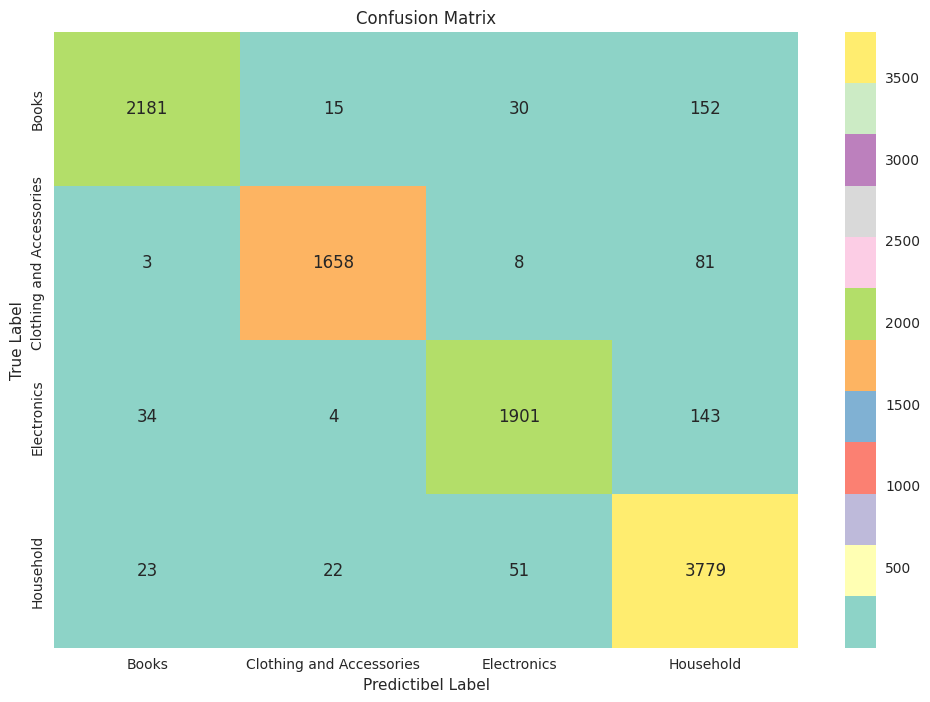

In [ ]:
label_name=['Books','Clothing and Accessories','Electronics','Household']
cf = confusion_matrix(y_test, pred)
plt.figure(figsize=(12,8))
sns.heatmap(cf,
            annot = True,
            fmt ='d',
            cmap ='Set3',
            xticklabels = label_name,
            yticklabels = label_name)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predictibel Label')
plt.show()

In [ ]:
print(classification_report(y_test, pred, target_names=label_name))

                          precision    recall  f1-score   support

                   Books       0.97      0.92      0.94      2378
Clothing and Accessories       0.98      0.95      0.96      1750
             Electronics       0.96      0.91      0.93      2082
               Household       0.91      0.98      0.94      3875

                accuracy                           0.94     10085
               macro avg       0.95      0.94      0.95     10085
            weighted avg       0.95      0.94      0.94     10085



In [ ]:
y_test.shape

(10085,)

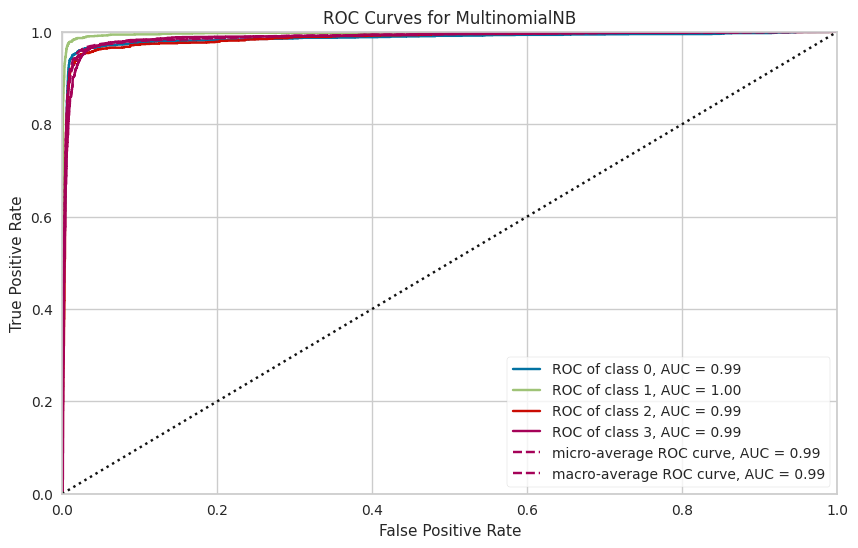

<Axes: title={'center': 'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
plt.figure(figsize=(10,6))
visual = ROCAUC(mb, classes=[0, 1, 2, 3])
visual.fit(X_train, y_train)
visual.score(X_test, y_test)
visual.show()

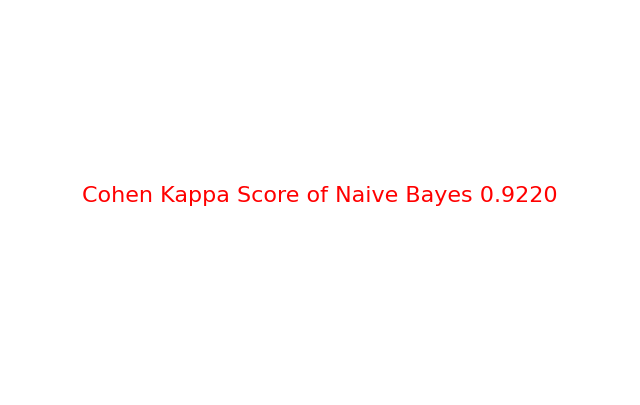

In [ ]:
kappa = cohen_kappa_score(y_test, pred)
plt.figure(figsize=(8,5))
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score of Naive Bayes {kappa:.4f}', fontsize=16, ha='center', color='red')

plt.axis('off')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

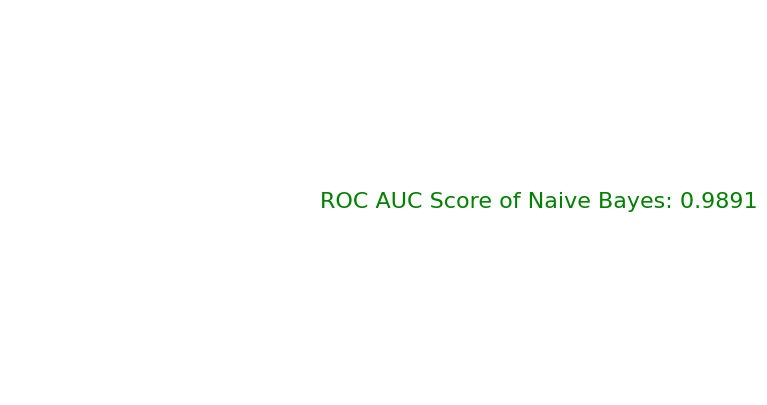

In [ ]:
y_prob = mb.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
plt.figure(figsize=(8,5))
plt.plot([])
plt.text(0,0, f'ROC AUC Score of Naive Bayes: {roc_auc:.4f}', fontsize=16, va='center', color='green')
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

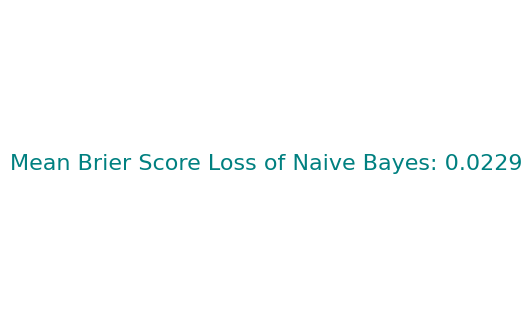

In [ ]:
brier_loss_per_class = [brier_score_loss((y_test == c).astype(int),y_prob[:, c]) for c in range(y_prob.shape[1])]
mean_brier_loss = np.mean(brier_loss_per_class)
plt.figure(figsize=(6, 4))
plt.plot([])
plt.text(0, 0, f'Mean Brier Score Loss of Naive Bayes: {mean_brier_loss:.4f}', fontsize=16, ha='center', va='center', color="teal")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

**Fast-text --> (skip-gram) + One-hot + GRU**

In [ ]:
max_len = 700
text_list = df_analisis['text'].str.split().tolist()
my_label = df_analisis['label1'].values

**Fast-text With Skipgram**

In [ ]:
fasttext_model = FastText(text_list,
                         vector_size=150,
                         window = 7,
                         min_count = 2,
                         workers = 8,
                         sg = 2)

**Check Word Embedding for a Particular Word**

In [ ]:
fasttext_model.wv['king']

array([ 0.19667143, -0.40163657,  0.02639842,  0.58986896,  0.11945548,
       -0.54301333,  0.14184393, -0.13354105,  0.47188756, -0.31499293,
        0.60903585,  0.02552079,  0.058175  ,  0.24497832, -0.21425048,
       -0.20265032,  0.2172675 ,  0.15670101,  0.1799604 ,  0.46897736,
        0.33843777, -0.86222595,  0.61583596,  1.1137652 , -0.03126378,
       -0.24025635, -0.2837008 ,  0.97762054,  0.08852828, -0.20132236,
       -0.81572366, -0.5928468 ,  0.5947987 , -0.01067267,  0.48848143,
       -0.0683634 , -0.5797738 , -0.0964168 , -0.23484197, -0.62043476,
        0.41793528, -0.57985383,  0.00792304, -0.02242525, -0.23269467,
       -0.25266466, -0.36526135, -0.07182131, -0.17420678,  0.09697162,
       -0.27081278,  0.19435297,  0.5039732 ,  0.2832494 , -0.07742865,
        0.23741859,  0.0381094 , -0.3877163 ,  0.5258143 , -0.13716777,
        0.6607046 , -0.48415506,  0.53120685,  0.33523008, -0.6275715 ,
       -0.04538989, -0.08579849,  0.16346873, -0.15335779,  0.26

In [ ]:
fasttext_model.wv['king'].shape

(150,)

**Check top 15 Similar Word for a Given Word by Gensim FastText**

In [ ]:
fasttext_model.wv.most_similar('wife', topn=15)

[('midwife', 0.8063315153121948),
 ('husband', 0.791206419467926),
 ('husbandry', 0.7822521924972534),
 ('husbandat', 0.736762523651123),
 ('husbands', 0.7339169979095459),
 ('granddaughter', 0.726243257522583),
 ('lives', 0.7032947540283203),
 ('Anusha', 0.6906772255897522),
 ('housewife', 0.6799485087394714),
 ('Californians', 0.6787143349647522),
 ('Massachusetts', 0.6755626797676086),
 ('daughters', 0.6658263802528381),
 ('Brooklyn', 0.6648373007774353),
 ('rife', 0.6609840989112854),
 ('DaughtersLife', 0.6597300171852112)]

In [ ]:
fasttext_model.wv.similarity('beer', 'drink')

0.46884245

***Kata yang Berlawanan***

In [ ]:
fasttext_model.wv.most_similar(negative=['cat'], topn=15)

[('Acc', 0.23016874492168427),
 ('Ref', 0.2080702930688858),
 ('Pr', 0.207704097032547),
 ('Exp', 0.18520468473434448),
 ('Ad', 0.18353088200092316),
 ('Ou', 0.17870797216892242),
 ('Em', 0.17108748853206635),
 ('Ev', 0.16624285280704498),
 ('Rev', 0.16593335568904877),
 ('Attn', 0.16330794990062714),
 ('Oc', 0.15910235047340393),
 ('Def', 0.15884201228618622),
 ('Exif', 0.15833786129951477),
 ('Accu', 0.15743528306484222),
 ('Imp', 0.15731805562973022)]

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_list)
text_seq = tokenizer.texts_to_sequences(text_list)
pad_seq = pad_sequences(text_seq, maxlen=max_len)

In [ ]:
vocab_size = len(fasttext_model.wv.key_to_index)
vocab = tokenizer.word_index
print('Vocab Size:', vocab_size)

Vocab Size: 71801


In [ ]:
embedding_matrix = fasttext_model.wv.vectors
embedding_matrix.shape

(71801, 150)

**One-Hot**

In [ ]:
texts = df_analisis['text']
one_hot_texts = [one_hot(text, vocab_size) for text in texts]
df_analisis['text'] = one_hot_texts
df_analisis

,text,label1
0,"[55864, 69160, 11911, 47923, 9087, 25864, 5476...",3
1,"[61211, 37600, 47923, 37723, 30477, 54885, 531...",3
2,"[61211, 33858, 23951, 38705, 16923, 20310, 479...",3
3,"[61211, 7784, 20310, 47923, 37723, 70722, 5488...",3
4,"[65544, 32142, 18760, 44491, 61793, 53739, 396...",3
...,...,...
50420,"[19282, 4476, 13971, 21955, 55269, 28030, 5808...",2
50421,"[10100, 61863, 36444, 64597, 59265, 20997, 110...",2
50422,"[4949, 29492, 28186, 10749, 44506, 4949, 29492...",2
50423,"[54446, 64477, 2153, 42895, 5816, 48338, 16897...",2


In [ ]:
my_onehot_data = df_analisis['text']
embedded_doc = pad_sequences(my_onehot_data,
                             padding='pre',
                             maxlen=max_len)
embedded_doc

array([[    0,     0,     0, ..., 58685, 35502, 43408],
       [    0,     0,     0, ..., 57625, 59912, 66394],
       [    0,     0,     0, ..., 55012, 66908, 23158],
       ...,
       [    0,     0,     0, ..., 10062, 16944, 68516],
       [    0,     0,     0, ..., 13318,  9279, 53831],
       [    0,     0,     0, ..., 61835, 10749, 44506]], dtype=int32)

In [ ]:
my_text = np.array(embedded_doc)
yy = df_analisis['label1']
my_label = np.array(yy)

In [ ]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(my_text, my_label, test_size=0.2, random_state=42)

**GRU MODEL**

In [ ]:
embedding_dim = 150
model = Sequential()
model.add(Embedding(input_dim = vocab_size,
                    output_dim = embedding_dim,
                    weights = [embedding_matrix],
                    input_length = max_len))
model.add(GRU(units=128,
              activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(4,
                activation = 'softmax'))
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      10,770,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,770,150 (41.08 MB)

 Trainable params: 10,770,150 (41.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train0, y_train0, validation_data = (X_test0, y_test0), epochs = 10, batch_size = 32)

Epoch 1/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 1674s 1s/step - accuracy: 0.7574 - loss: 0.6089 - val_accuracy: 0.9676 - val_loss: 0.1210
Epoch 2/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 1660s 1s/step - accuracy: 0.9797 - loss: 0.0766 - val_accuracy: 0.9755 - val_loss: 0.0922
Epoch 3/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 1662s 1s/step - accuracy: 0.9912 - loss: 0.0335 - val_accuracy: 0.9785 - val_loss: 0.0841
Epoch 4/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 1717s 1s/step - accuracy: 0.9959 - loss: 0.0151 - val_accuracy: 0.9745 - val_loss: 0.1002
Epoch 5/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 1673s 1s/step - accuracy: 0.9971 - loss: 0.0109 - val_accuracy: 0.9816 - val_loss: 0.0922
Epoch 6/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 1684s 1s/step - accuracy: 0.9986 - loss: 0.0053 - val_accuracy: 0.9812 - val_loss: 0.0985
Epoch 7/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 1696s 1s/step - accuracy: 0.9977 - loss: 0.0079 - val_accuracy: 0.9820 - val_loss: 0.0989
Epoch 8/10
1261/1261 ━━━━━━━━━━━━━━━━━━━━ 1679s 1s/step - accuracy: 0.9982 -

**Plot Model Accuracy dengan Validation Accuracy dan Loss**

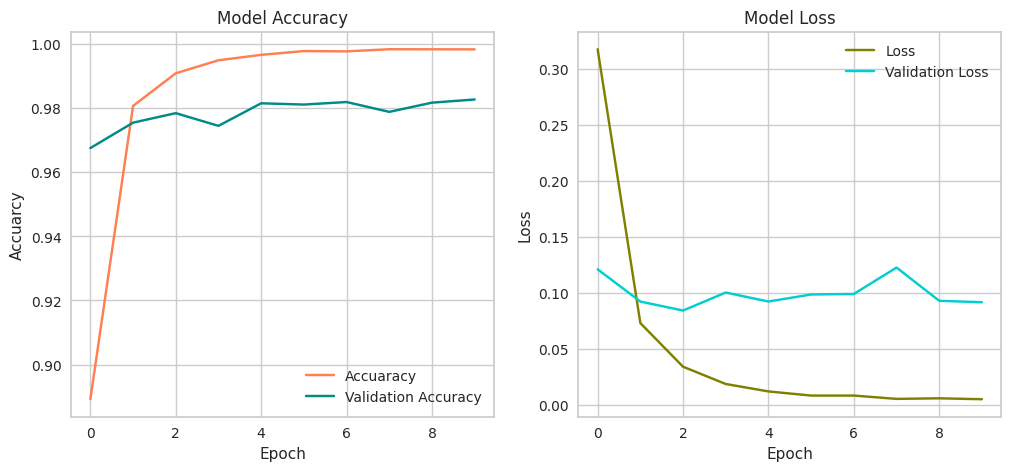

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].plot(history.history['accuracy'], label='Accuaracy', color='coral')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkcyan')
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuarcy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='best')

ax[1].plot(history.history['loss'], label='Loss', color='olive')
ax[1].plot(history.history['val_loss'], label='Validation Loss', color='darkturquoise')
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='best')
plt.show()

In [ ]:
pred2 = model.predict(X_test0)
final_predict = np.argmax(pred2, axis=1)

316/316 ━━━━━━━━━━━━━━━━━━━━ 83s 263ms/step


**Confusion Matrix**

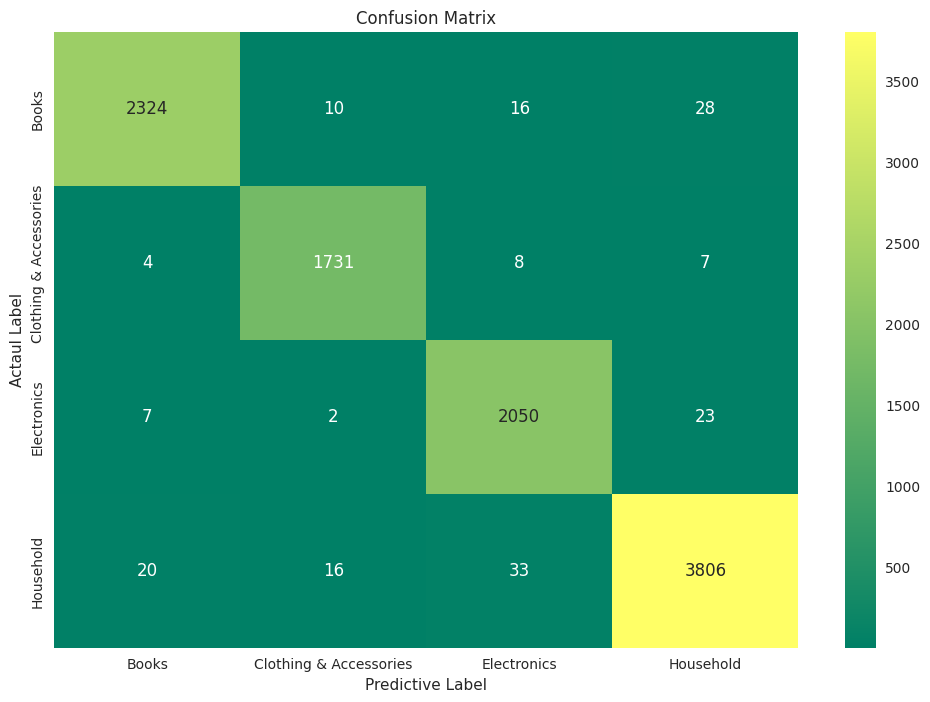

In [ ]:
label_name = ['Books','Clothing & Accessories','Electronics','Household']
cf = confusion_matrix(y_test0, final_predict)
plt.figure(figsize=(12,8))
sns.heatmap(cf,
            annot=True,
            fmt='d',
            cmap='summer',
            xticklabels=label_name,
            yticklabels=label_name)
plt.title('Confusion Matrix')
plt.xlabel('Predictive Label')
plt.ylabel('Actaul Label')
plt.show()

**Classification Report**

In [ ]:
print(classification_report(y_test0, final_predict, target_names=label_name))

                        precision    recall  f1-score   support

                 Books       0.99      0.98      0.98      2378
Clothing & Accessories       0.98      0.99      0.99      1750
           Electronics       0.97      0.98      0.98      2082
             Household       0.98      0.98      0.98      3875

              accuracy                           0.98     10085
             macro avg       0.98      0.98      0.98     10085
          weighted avg       0.98      0.98      0.98     10085



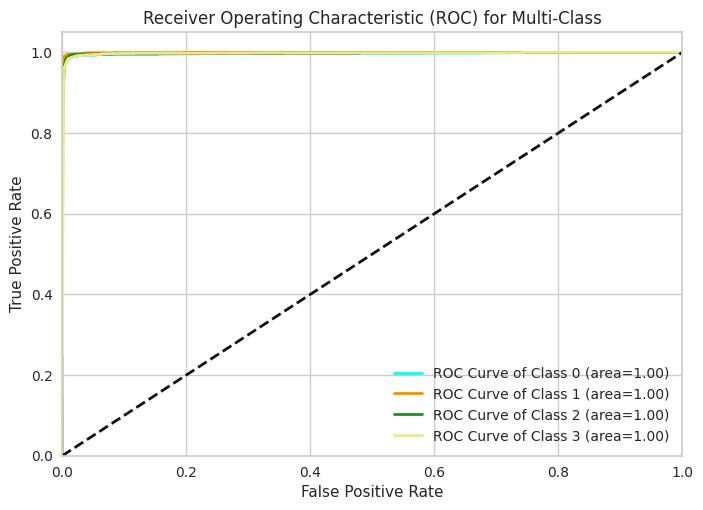

In [ ]:
n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
  fpr[i], tpr[i], _ = roc_curve(y_test0 == i, pred2[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
colors = cycle(['aqua','darkorange','forestgreen','khaki'])


for i, color in zip(range(n_classes), colors):
  plt.plot(fpr[i],
           tpr[i],
           color=color,
           lw=2,
           label='ROC Curve of Class {0} (area={1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0,1],[0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc='lower right')
plt.show()

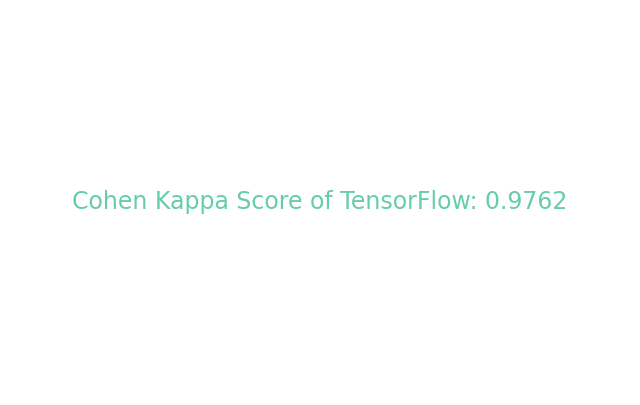

In [ ]:
kappa = cohen_kappa_score(y_test0, final_predict)
plt.figure(figsize=(8,5))
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score of TensorFlow: {kappa:.4f}',
         fontsize=17,
         ha='center',
         va='center',
         color='mediumaquamarine')
plt.axis('off')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

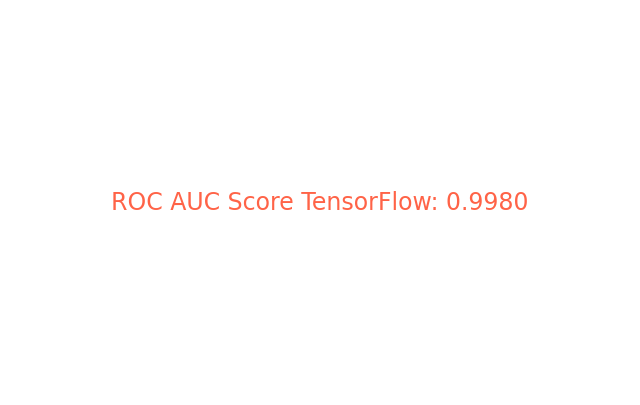

In [ ]:
roc_auc = roc_auc_score(y_test0, pred2, multi_class='ovr')
plt.figure(figsize=(8,5))
plt.plot([])
plt.text(0,0, f'ROC AUC Score TensorFlow: {roc_auc:.4f}',
         fontsize=17,
         ha='center',
         va='center',
         color='tomato')
plt.axis('off')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

316/316 ━━━━━━━━━━━━━━━━━━━━ 83s 263ms/step


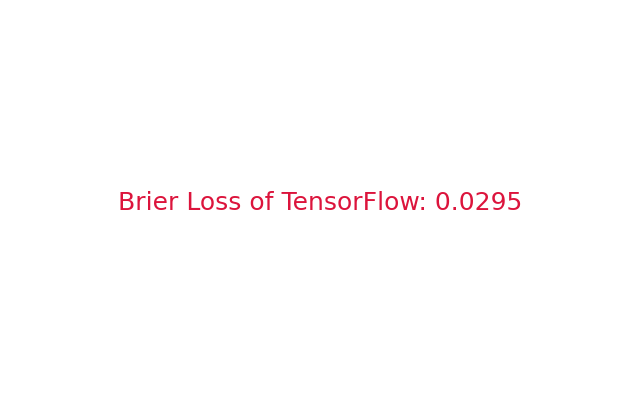

In [ ]:
pred_prob = model.predict(X_test0)
one_hot_true = np.zeros_like(pred_prob)
one_hot_true[np.arange(len(y_test0)), y_test] = 1
brier_loss = np.mean(np.sum((pred_prob - one_hot_true) **2, axis=1))
plt.figure(figsize=(8,5))
plt.plot([])
plt.text(0,0, f'Brier Loss of TensorFlow: {brier_loss:.4f}',
         fontsize=18,
         ha='center',
         va='center',
         color='crimson')
plt.axis('off')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()